In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/comp5331/comp5331

/content/drive/My Drive/comp5331/comp5331


In [ ]:
from data_loader import ImbalanceDataset
from model import model, loss
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from  torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
trainset, testset = ImbalanceDataset.get_dataset("fminst")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=200,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=200,shuffle=True)

In [ ]:
args = {}
args['dim_h'] = 40         # factor controlling size of hidden layers
args['n_channel'] = 1      # number of channels in the input data (MNIST = 1, greyscale)
args['n_z'] = 100           # number of dimensions in latent space. 
args['n_class'] = 10           # number of classes. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.00005        # learning rate for Adam optimizer
args['epochs'] = 20       # how many epochs to run for
args['batch_size'] = 256   # batch size for SGD
args['save'] = True       # save weights at each epoch of training if True
args['train'] = True      # train networks if True, else load networks from saved weights
args['dataset'] = 'mnist' # specify which dataset to use
args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [ ]:
classes_freq = {}
for _, labels in train_loader:
  for label in labels: 
    classes_freq[label.item()] = classes_freq.get(label.item(), 0) + 1

classes_freq

{0: 4000,
 1: 2000,
 2: 1000,
 3: 750,
 4: 500,
 5: 350,
 6: 200,
 7: 100,
 8: 60,
 9: 40}

#Stage 1: train the latent space

## SCDL

In [ ]:
from model import model, loss

In [ ]:
scdl = model.AE(args = args)
scdl = scdl.to(args['device'])

In [ ]:
#Assume normal distribution
def sample_z(n_sample=None, dim=None, sigma=None, template=None):
  return sigma*Variable(template.data.new(template.size()).normal_())

In [ ]:
losses = []
recon_losses = []
mmd_losses = []
sv_losses = []

lambda_1, lambda_2 = torch.tensor(1), torch.tensor(1)

optim = torch.optim.Adam(scdl.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
CEL = nn.CrossEntropyLoss()
for epoch in range(args['epochs']): 
  match_sum, sv_sum, recon_sum = 0, 0, 0
  for images, labels in tqdm(train_loader):
    images = images.to(args['device'])
    labels = labels.to(args['device'])

    optim.zero_grad()
  
    x_recon, z_tilde, y_pred = scdl(images)
    z = loss.sample_z(template=z_tilde, sigma=args['sigma'])

    recon_loss = loss.mse_loss(x_recon, images ,train_loader.batch_size, size_average=False)
    mmd_loss = loss.mmd(z_tilde, z, z_var=args['sigma'])
    sv_loss = CEL(y_pred, labels)


    total_loss = recon_loss +lambda_1 *mmd_loss + lambda_2*sv_loss
    match_sum += mmd_loss.item()
    sv_sum += sv_loss.item()
    recon_sum += recon_loss.item()
    
    recon_losses.append(recon_loss.item())

    mmd_losses.append(mmd_loss.item())
    sv_losses.append(sv_loss.item())
    losses.append(total_loss.item())
    total_loss.backward()
    optim.step()
  lambda_1 = 0.5 *lambda_1 + 0.25 *(match_sum/recon_sum + match_sum/sv_sum )
  lambda_2 = 0.5 *lambda_2 + 0.25 *(sv_sum/recon_sum + sv_sum/match_sum )
  print("\n",lambda_1, lambda_2)

  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 3/45 [00:00<00:01, 27.87it/s]


 tensor(0.5250) tensor(3.0218)


  7%|▋         | 3/45 [00:00<00:01, 25.54it/s]


 tensor(0.2923) tensor(3.6506)


  7%|▋         | 3/45 [00:00<00:01, 26.03it/s]


 tensor(0.1774) tensor(3.8702)


  7%|▋         | 3/45 [00:00<00:01, 28.63it/s]


 tensor(0.1215) tensor(3.8957)


  7%|▋         | 3/45 [00:00<00:01, 28.01it/s]


 tensor(0.0950) tensor(3.8264)


  7%|▋         | 3/45 [00:00<00:01, 25.24it/s]


 tensor(0.0849) tensor(3.6408)


  7%|▋         | 3/45 [00:00<00:01, 26.18it/s]


 tensor(0.0838) tensor(3.3848)


  7%|▋         | 3/45 [00:00<00:01, 27.12it/s]


 tensor(0.0863) tensor(3.1561)


  7%|▋         | 3/45 [00:00<00:01, 27.21it/s]


 tensor(0.0904) tensor(2.9551)


  7%|▋         | 3/45 [00:00<00:01, 28.51it/s]


 tensor(0.0952) tensor(2.7809)


  7%|▋         | 3/45 [00:00<00:01, 28.40it/s]


 tensor(0.0997) tensor(2.6432)


  7%|▋         | 3/45 [00:00<00:01, 28.35it/s]


 tensor(0.1041) tensor(2.5264)


  7%|▋         | 3/45 [00:00<00:01, 27.80it/s]


 tensor(0.1078) tensor(2.4361)


  7%|▋         | 3/45 [00:00<00:01, 27.79it/s]


 tensor(0.1113) tensor(2.3585)


  7%|▋         | 3/45 [00:00<00:01, 28.86it/s]


 tensor(0.1147) tensor(2.2890)


  7%|▋         | 3/45 [00:00<00:01, 27.22it/s]


 tensor(0.1183) tensor(2.2210)


  7%|▋         | 3/45 [00:00<00:01, 27.48it/s]


 tensor(0.1212) tensor(2.1702)


  7%|▋         | 3/45 [00:00<00:01, 27.90it/s]


 tensor(0.1236) tensor(2.1301)


  7%|▋         | 3/45 [00:00<00:01, 26.81it/s]


 tensor(0.1262) tensor(2.0869)


100%|██████████| 45/45 [00:01<00:00, 27.70it/s]


 tensor(0.1285) tensor(2.0509)


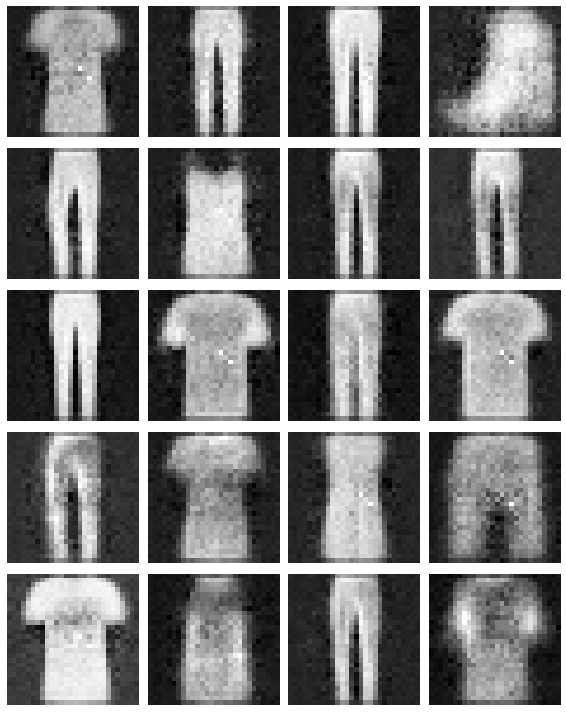

In [ ]:
ROW = 5
COLUMN = 4

x = torch.Tensor.cpu(x_recon.detach()).data[:25].numpy()

fname = 'reconstruct_scdl.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

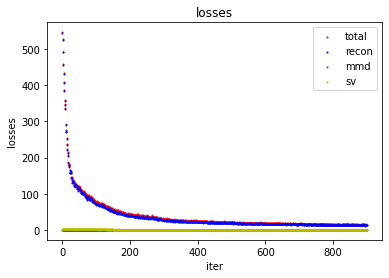

In [ ]:
x_data = list(range(len(losses)))
# From here the plotting starts
plt.scatter(x_data, losses, c='r', label='total',s=1)
plt.scatter(x_data, recon_losses, c='b', label='recon',s=1)
plt.scatter(x_data, mmd_losses, c='g', label='mmd', s=1)
plt.scatter(x_data, sv_losses, c='y', label='sv', s=1)


plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

No handles with labels found to put in legend.


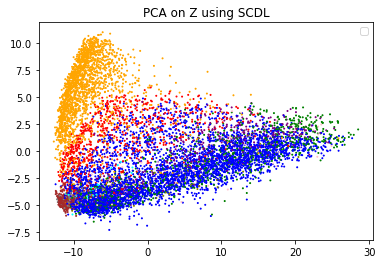

In [ ]:
c = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scdl.eval()
# in this block, we use cpu as sklearn does not support GPU
scdl = scdl.to('cpu')

pca = PCA(2)
plt.title("PCA on Z using SCDL")
Z = None
for images, labels in train_loader:

  x_recon, z_tilde, y_pred = scdl(images)
  if Z == None:
    Z = z_tilde
  else:
    Z = torch.cat((Z,z_tilde), dim=0)

pca.fit(Z.data)
for images, labels in train_loader:

  color = [c[i] for i in labels]

  x_recon, z_tilde, y_pred = scdl(images)
  res=pd.DataFrame(pca.transform(z_tilde.data))
  Z = np.array(res)

  b1 = plt.scatter(Z[:,0], Z[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

No handles with labels found to put in legend.


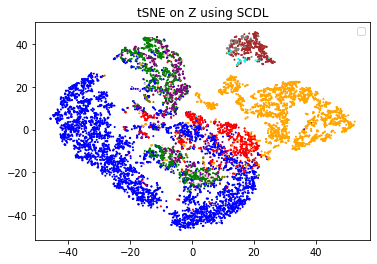

In [ ]:
tsne = TSNE(n_jobs=8)
Z = None
color = None
for images, labels in train_loader:
  x_recon, z_tilde, y_pred = scdl(images)
  if Z == None:
    Z = z_tilde
    color = [c[i] for i in labels]
  else:
    Z = torch.cat((Z,z_tilde), dim=0)
    color = color + [c[i] for i in labels]
Y = np.array(tsne.fit_transform(Z.data))
plt.title("tSNE on Z using SCDL")

b1 = plt.scatter(Y[:,0], Y[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

In [ ]:
def get_class_distribution(ae, target_class):
  z_c = torch.zeros(size=(1, 100))
  for i, (images, labels) in enumerate(train_loader):
    z = ae.encoder(images)
    if i == 0:
      z_c = z[labels == target_class]
    else:
      z_c = torch.cat((z_c, z[labels == target_class]), dim=0)

  return z_c.mean(dim=0), z_c.std(dim=0)

In [ ]:
mean_0, std_0 = get_class_distribution(scdl, 0)

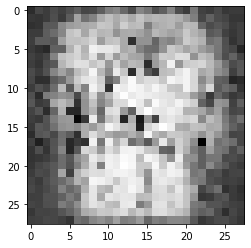

In [ ]:
# sample some class
fake_0 = mean_0 + torch.randn(std_0.shape) * std_0
fake = scdl.decoder(fake_0)

plt.imshow(torch.Tensor.cpu(fake.detach()).view((28, 28)), cmap='gray')
plt.show()

In [ ]:
mean_0.shape

torch.Size([100])

## WAE

In [ ]:
wae = model.AE(args = args)
wae = wae.to(args['device'])

In [ ]:
losses = []
recon_losses = []
mmd_losses = []
#sv_losses = []

lambda_1, lambda_2 = torch.tensor(1), torch.tensor(1)

optim = torch.optim.Adam(wae.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
CEL = nn.CrossEntropyLoss()
for epoch in range(args['epochs']): 
  match_sum, recon_sum = 0, 0, 
  for images, labels in tqdm(train_loader):
    images = images.to(args['device'])
    labels = labels.to(args['device'])
  
    x_recon, z_tilde, _ = wae(images)
    z = loss.sample_z(template=z_tilde, sigma=args['sigma'])

    recon_loss = loss.mse_loss(x_recon, images ,train_loader.batch_size, size_average=False)
    mmd_loss = loss.mmd(z_tilde, z, z_var=args['sigma'])
    # sv_loss = CEL(y_pred, labels)
    # the only difference in wae is that it does not include the sv_loss
    # the exact same model and architecture is used


    total_loss = recon_loss +lambda_1 *mmd_loss
    match_sum += mmd_loss.item()
    recon_sum += recon_loss.item()
    
    recon_losses.append(recon_loss.item())
    mmd_losses.append(mmd_loss.item())
    losses.append(total_loss.item())

    optim.zero_grad()
    total_loss.backward()
    optim.step()
  lambda_1 = 0.5 *lambda_1 + 0.25 *(match_sum/recon_sum + match_sum/sv_sum )
  #lambda_2 = 0.5 *lambda_2 + 0.25 *(sv_sum/recon_sum + sv_sum/match_sum )
  print("\n",lambda_1)


  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

100%|██████████| 45/45 [00:01<00:00, 26.53it/s]

  7%|▋         | 3/45 [00:00<00:01, 26.23it/s]


 tensor(0.5700)



100%|██████████| 45/45 [00:01<00:00, 27.64it/s]

  7%|▋         | 3/45 [00:00<00:01, 28.41it/s]


 tensor(0.3615)



100%|██████████| 45/45 [00:01<00:00, 27.84it/s]

  7%|▋         | 3/45 [00:00<00:01, 29.09it/s]


 tensor(0.2525)



100%|██████████| 45/45 [00:01<00:00, 27.58it/s]

  7%|▋         | 3/45 [00:00<00:01, 26.31it/s]


 tensor(0.1939)



100%|██████████| 45/45 [00:01<00:00, 27.63it/s]

  7%|▋         | 3/45 [00:00<00:01, 28.27it/s]


 tensor(0.1614)



100%|██████████| 45/45 [00:01<00:00, 27.89it/s]

  7%|▋         | 3/45 [00:00<00:01, 26.97it/s]


 tensor(0.1429)



100%|██████████| 45/45 [00:01<00:00, 27.63it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.11it/s]


 tensor(0.1314)



100%|██████████| 45/45 [00:01<00:00, 27.65it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.96it/s]


 tensor(0.1241)



100%|██████████| 45/45 [00:01<00:00, 27.71it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.17it/s]


 tensor(0.1197)



100%|██████████| 45/45 [00:01<00:00, 27.84it/s]

  7%|▋         | 3/45 [00:00<00:01, 28.46it/s]


 tensor(0.1165)



100%|██████████| 45/45 [00:01<00:00, 27.75it/s]

  7%|▋         | 3/45 [00:00<00:01, 28.04it/s]


 tensor(0.1150)



100%|██████████| 45/45 [00:01<00:00, 27.44it/s]

  7%|▋         | 3/45 [00:00<00:01, 28.07it/s]


 tensor(0.1149)



100%|██████████| 45/45 [00:01<00:00, 27.08it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.01it/s]


 tensor(0.1155)



100%|██████████| 45/45 [00:01<00:00, 27.33it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.78it/s]


 tensor(0.1162)



100%|██████████| 45/45 [00:01<00:00, 27.29it/s]

  7%|▋         | 3/45 [00:00<00:01, 29.07it/s]


 tensor(0.1177)



100%|██████████| 45/45 [00:01<00:00, 27.48it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.16it/s]


 tensor(0.1193)



100%|██████████| 45/45 [00:01<00:00, 27.34it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.88it/s]


 tensor(0.1210)



100%|██████████| 45/45 [00:01<00:00, 27.09it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.33it/s]


 tensor(0.1231)



100%|██████████| 45/45 [00:01<00:00, 27.23it/s]

  7%|▋         | 3/45 [00:00<00:01, 27.99it/s]


 tensor(0.1251)



100%|██████████| 45/45 [00:01<00:00, 27.05it/s]


 tensor(0.1268)


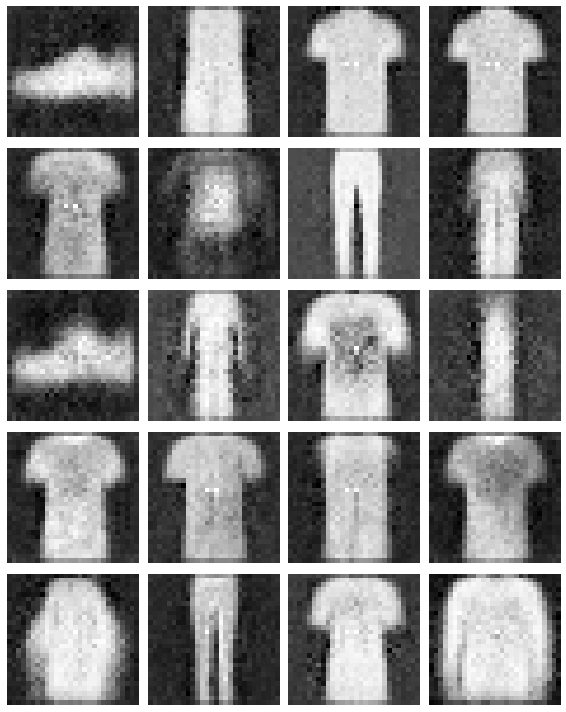

In [ ]:
ROW = 5
COLUMN = 4

x = torch.Tensor.cpu(x_recon.detach()).data[:25].numpy()

fname = 'reconstruct_wae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

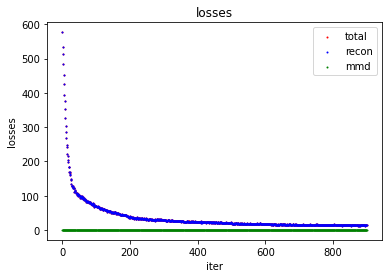

In [ ]:
x_data = list(range(len(losses)))
# From here the plotting starts
plt.scatter(x_data, losses, c='r', label='total',s=1)
plt.scatter(x_data, recon_losses, c='b', label='recon',s=1)
plt.scatter(x_data, mmd_losses, c='g', label='mmd', s=1)
#plt.scatter(x_data, sv_losses, c='y', label='sv', s=1)


plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

No handles with labels found to put in legend.


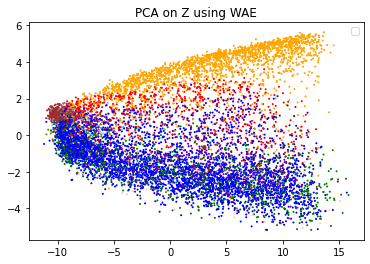

In [ ]:
c = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

wae.eval()
# in this block, we use cpu as sklearn does not support GPU
wae = wae.to('cpu')

pca = PCA(2)
plt.title("PCA on Z using WAE")
Z = None
for images, labels in train_loader:

  x_recon, z_tilde, y_pred = wae(images)
  if Z == None:
    Z = z_tilde
  else:
    Z = torch.cat((Z,z_tilde), dim=0)

pca.fit(Z.data)
for images, labels in train_loader:

  color = [c[i] for i in labels]

  x_recon, z_tilde, y_pred = wae(images)
  res=pd.DataFrame(pca.transform(z_tilde.data))
  Z = np.array(res)

  b1 = plt.scatter(Z[:,0], Z[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

No handles with labels found to put in legend.


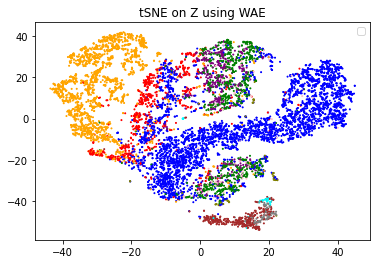

In [ ]:
tsne = TSNE(n_jobs=8)
Z = None
color = None
for images, labels in train_loader:
  x_recon, z_tilde, y_pred = wae(images)
  if Z == None:
    Z = z_tilde
    color = [c[i] for i in labels]
  else:
    Z = torch.cat((Z,z_tilde), dim=0)
    color = color + [c[i] for i in labels]
Y = np.array(tsne.fit_transform(Z.data))
plt.title("tSNE on Z using WAE")

b1 = plt.scatter(Y[:,0], Y[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

In [ ]:
mean_0, std_0 = get_class_distribution(wae, 0)

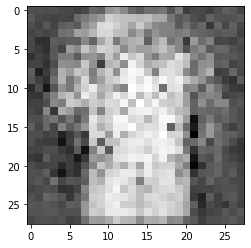

In [ ]:
# sample some class
fake_0 = mean_0 + torch.randn(std_0.shape) * std_0
fake = wae.decoder(fake_0)

plt.imshow(torch.Tensor.cpu(fake.detach()).view((28, 28)), cmap='gray')
plt.show()

## Autoencoder

In [ ]:
ae = model.AE(args = args)
ae = ae.to(args['device'])

In [ ]:
losses = []
recon_losses = []
#mmd_losses = []
#sv_losses = []

#lambda_1, lambda_2 = torch.tensor(1), torch.tensor(1)

optim = torch.optim.Adam(ae.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
CEL = nn.CrossEntropyLoss()
for epoch in range(args['epochs']): 
  recon_sum = 0
  for images, labels in tqdm(train_loader):
    images = images.to(args['device'])
    labels = labels.to(args['device'])
  
    x_recon, z_tilde, _ = ae(images)
    z = loss.sample_z(template=z_tilde, sigma=args['sigma'])

    recon_loss = loss.mse_loss(x_recon, images ,train_loader.batch_size, size_average=False)
    # mmd_loss = loss.mmd(z_tilde, z, z_var=args['sigma'])
    # sv_loss = CEL(y_pred, labels)
    # autoencoder only use reconstruction loss, so discard mmd_loss and sv_loss in scdl


    total_loss = recon_loss
    # match_sum += mmd_loss.item()
    recon_sum += recon_loss.item()
    
    recon_losses.append(recon_loss.item())
    # mmd_losses.append(mmd_loss.item())
    losses.append(total_loss.item())

    optim.zero_grad()
    total_loss.backward()
    optim.step()
  #lambda_1 = 0.5 *lambda_1 + 0.25 *(match_sum/recon_sum + match_sum/sv_sum )
  #lambda_2 = 0.5 *lambda_2 + 0.25 *(sv_sum/recon_sum + sv_sum/match_sum )
  #print("\n",lambda_1, lambda_2)


  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

100%|██████████| 45/45 [00:01<00:00, 33.83it/s]

100%|██████████| 45/45 [00:01<00:00, 36.46it/s]

100%|██████████| 45/45 [00:01<00:00, 36.09it/s]

100%|██████████| 45/45 [00:01<00:00, 35.82it/s]

100%|██████████| 45/45 [00:01<00:00, 36.30it/s]

100%|██████████| 45/45 [00:01<00:00, 35.93it/s]

100%|██████████| 45/45 [00:01<00:00, 36.23it/s]

100%|██████████| 45/45 [00:01<00:00, 35.35it/s]

100%|██████████| 45/45 [00:01<00:00, 35.91it/s]

100%|██████████| 45/45 [00:01<00:00, 34.61it/s]

100%|██████████| 45/45 [00:01<00:00, 34.97it/s]

100%|██████████| 45/45 [00:01<00:00, 35.25it/s]

100%|██████████| 45/45 [00:01<00:00, 35.42it/s]

100%|██████████| 45/45 [00:01<00:00, 35.34it/s]

100%|██████████| 45/45 [00:01<00:00, 35.74it/s]

100%|██████████| 45/45 [

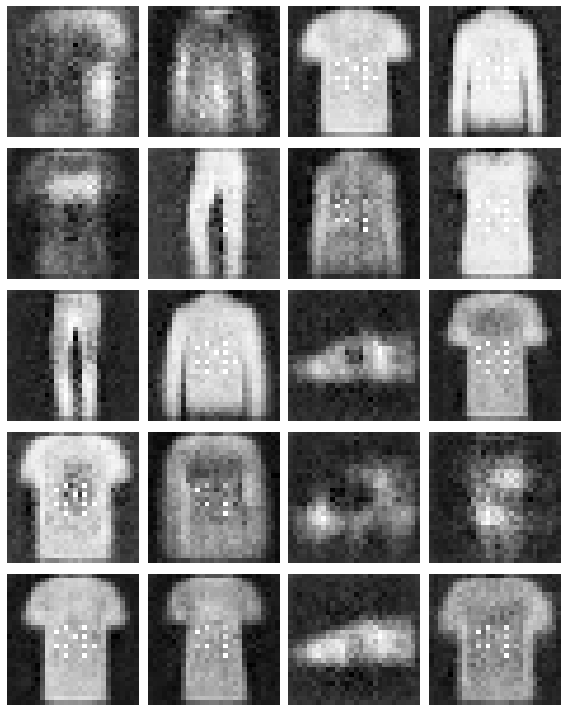

In [ ]:
ROW = 5
COLUMN = 4

x = torch.Tensor.cpu(x_recon.detach()).data[:25].numpy()

fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

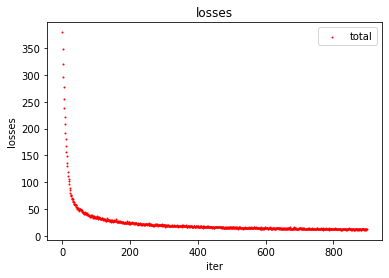

In [ ]:
x_data = list(range(len(losses)))
# From here the plotting starts
plt.scatter(x_data, losses, c='r', label='total',s=1)
#plt.scatter(x_data, recon_losses, c='b', label='recon',s=1)
#plt.scatter(x_data, mmd_losses, c='g', label='mmd', s=1)
#plt.scatter(x_data, sv_losses, c='y', label='sv', s=1)


plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

No handles with labels found to put in legend.


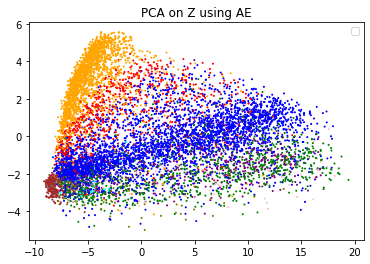

In [ ]:
c = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

ae.eval()
# in this block, we use cpu as sklearn does not support GPU
ae = ae.to('cpu')

pca = PCA(2)
plt.title("PCA on Z using AE")
Z = None
for images, labels in train_loader:

  x_recon, z_tilde, y_pred = ae(images)
  if Z == None:
    Z = z_tilde
  else:
    Z = torch.cat((Z,z_tilde), dim=0)

pca.fit(Z.data)
for images, labels in train_loader:

  color = [c[i] for i in labels]

  x_recon, z_tilde, y_pred = ae(images)
  res=pd.DataFrame(pca.transform(z_tilde.data))
  Z = np.array(res)

  b1 = plt.scatter(Z[:,0], Z[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

No handles with labels found to put in legend.


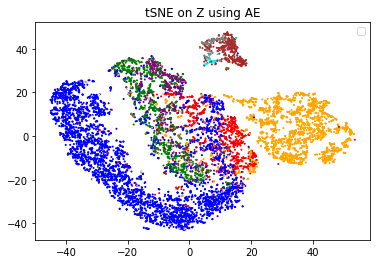

In [ ]:
tsne = TSNE(n_jobs=8)
Z = None
color = None
for images, labels in train_loader:
  x_recon, z_tilde, y_pred = ae(images)
  if Z == None:
    Z = z_tilde
    color = [c[i] for i in labels]
  else:
    Z = torch.cat((Z,z_tilde), dim=0)
    color = color + [c[i] for i in labels]
Y = np.array(tsne.fit_transform(Z.data))
plt.title("tSNE on Z using AE")

b1 = plt.scatter(Y[:,0], Y[:,1], c=color,s=1)
plt.legend(loc="upper right")
plt.show()

In [ ]:
mean_0, std_0 = get_class_distribution(ae, 0)

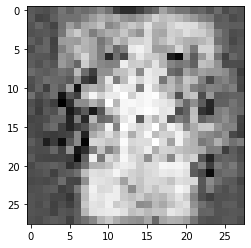

In [ ]:
# sample some class
fake_0 = mean_0 + torch.randn(std_0.shape) * std_0
fake = ae.decoder(fake_0)

plt.imshow(torch.Tensor.cpu(fake.detach()).view((28, 28)), cmap='gray')
plt.show()

#Stage 2: initialize GAN

## SCDL-GAN

In [ ]:
import copy

encoder = copy.deepcopy(scdl.encoder)

netG = copy.deepcopy(scdl.decoder) # start the generator with the weight of the trained decoder
netD = model.GAN_Classifier(args, 10)

netD.disc[0] = copy.deepcopy(scdl.encoder[0]) # warm start the weight of the first layer

In [ ]:
# Initialize BCELoss function
criterion = nn.CrossEntropyLoss()

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=args['lr'])
optimizerG = torch.optim.Adam(netG.parameters(), lr=args['lr'])

In [ ]:
# Using GPU again
netG = netG.to(args['device'])
netD = netD.to(args['device'])
encoder = encoder.to(args['device'])

In [ ]:
netD

GAN_Classifier(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 100, kernel_size=(4, 4), stride=(2, 2))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (3): Linear(in_features=100, out_features=11, bias=True)
  )
)

In [ ]:
netG

Sequential(
  (0): View()
  (1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [ ]:
### load models if there are
netD = torch.load('fminst_SCDLGAN_D')
netG = torch.load('fminst_SCDLGAN_G')

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

args['epochs'] = 300

print("Starting Training Loop...")
plot_the_graph = False # indicate if you want to plot some graphs during the training process
# For each epoch
for epoch in range(args['epochs']):
    # For each batch in the dataloader
    for  images, labels in tqdm(train_loader):

      images = images.to(args['device'])
      labels = labels.to(args['device'])

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      netD.train()
      netG.eval()

      optimizerD.zero_grad()

      # Forward pass real batch through D
      real_predict = netD(images)

      # Calculate loss on all-real batch
      errD_real = criterion(real_predict, labels)
      #print(real_predict.argmax(dim=1))
      #print(labels)

      ## Train with all-fake batch
      images_z = encoder(images)

      # Generate fake image batch with G
      fake = netG(images_z)

      # Make fake_labels
      fake_labels = torch.ones(len(labels)) * 10
      fake_labels = fake_labels.type(torch.LongTensor)
      fake_labels = fake_labels.to(args['device'])

      #print(fake_labels)

      # Classify all fake batch with D
      fake_predict = netD(fake.detach())

      #print('prediction: ', fake_predict.argmax(dim=1))
      #print('fake:', fake_labels)
      
      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(fake_predict, fake_labels)

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Calculate the gradients
      errD.backward()
      # Update D
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.train()

      optimizerG.zero_grad()
      # Since we just updated D, perform another forward pass of all-fake batch through D

      fake = netG(images_z.detach())
      fake_predict = netD(fake)
      # Calculate G's loss based on this output
      errG = criterion(fake_predict, labels)
      # Calculate gradients for G
      errG.backward()
      # Update G
      optimizerG.step()

      #print("fake", fake_predict.argmax(dim=1))
      #print("real", real_predict.argmax(dim=1))

      # Output training stats
      if iters % 50 == 0 and plot_the_graph:
        #plt.imshow(torch.Tensor.cpu(fake[0].detach()).view((28, 28)), cmap='gray')
        #plt.show()
        #plt.imshow(torch.Tensor.cpu(images[0].detach()).view((28, 28)), cmap='gray')
        #plt.show()
        
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
            % (epoch, args['epochs'], iters, len(train_loader),
                errD.item(), errG.item()))
        
        print("real predict accuracy: ", (real_predict.argmax(dim=1) == labels).sum().item()/len(labels))
        print("fake predict accuracy: ", (fake_predict.argmax(dim=1) == fake_labels).sum().item()/len(fake_labels))

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      iters += 1
SCDLGAN_D = netD
SCDLGAN_G = netG


  4%|▍         | 2/45 [00:00<00:03, 11.71it/s]

Starting Training Loop...


Streaming output truncated to the last 5000 lines.
100%|██████████| 45/45 [00:02<00:00, 18.16it/s]

100%|██████████| 45/45 [00:02<00:00, 18.45it/s]

100%|██████████| 45/45 [00:02<00:00, 18.58it/s]

100%|██████████| 45/45 [00:02<00:00, 18.48it/s]

100%|██████████| 45/45 [00:02<00:00, 18.68it/s]

100%|██████████| 45/45 [00:02<00:00, 18.51it/s]

100%|██████████| 45/45 [00:02<00:00, 18.57it/s]

100%|██████████| 45/45 [00:02<00:00, 18.21it/s]

100%|██████████| 45/45 [00:02<00:00, 18.68it/s]

100%|██████████| 45/45 [00:02<00:00, 18.64it/s]

100%|██████████| 45/45 [00:02<00:00, 18.39it/s]

100%|██████████| 45/45 [00:02<00:00, 18.62it/s]

100%|██████████| 45/45 [00:02<00:00, 18.29it/s]

100%|██████████| 45/45 [00:02<00:00, 18.34it/s]

100%|██████████| 45/45 [00:02<00:00, 18.28it/s]

100%|██████████| 45/45 [00:02<00:00, 18.18it/s]

100%|██████████| 45/45 [00:02<00:00, 18.33it/s]

100%|██████████| 45/45 [00:02<00:00, 18.34it/s]

100%|██████████| 45/45 [00:02<00:00, 18.34it/s]

100%|██████████| 4

### Save model

In [ ]:
torch.save(SCDLGAN_D, "fminst_SCDLGAN_D")
torch.save(SCDLGAN_G, "fminst_SCDLGAN_G")

### Generate balance data

In [ ]:
### Generate a balance dataset through SCDL-GAN
import torch

def generate_data(netG, name, classes, classes_distribution, latent):
  labels = torch.full(size=(1,classes_distribution[0]), fill_value=0)
  mean_0, std_0 = get_class_distribution(latent, 0) 
  fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0
  images = netG(fake_0.cuda())

  with torch.no_grad():
    netG.eval()
    for i in classes:
      if(i > 0):
        mean_0, std_0 = get_class_distribution(latent, i) 
        fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0
        img = netG(fake_0.cuda())
        images = torch.cat((images, img),0)
        labels = torch.cat((labels, torch.full(size=(1,classes_distribution[i]), fill_value=i)),1)

      for j in tqdm(range(classes_distribution[i]-1)):
        #mean_0, std_0 = get_class_distribution(scdl, i) 
        fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0 # sample z of class 0
        img = netG(fake_0.cuda())
        images = torch.cat((images, img),0)
        #plt.imshow(torch.Tensor.cpu(img).view((28, 28)), cmap='gray')
        #plt.show()
    print(labels[0].shape)
    print(images.shape)
    dataset = torch.utils.data.TensorDataset(images, labels[0])
    torch.save(dataset, 'FMNIST_balance/'+name)

name = 'SCDLGAN_4000.pt'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes_distribution = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
generate_data(netG, name, classes, classes_distribution, scdl)

100%|██████████| 3999/3999 [00:07<00:00, 517.57it/s]


torch.Size([40000])
torch.Size([40000, 1, 28, 28])


### Result Evaluation

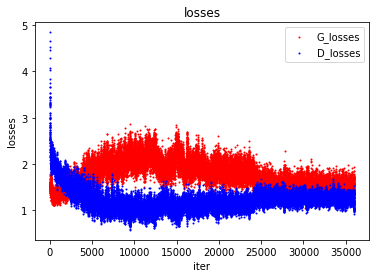

In [ ]:
x_data = list(range(len(G_losses)))
# From here the plotting starts
plt.scatter(x_data, G_losses, c='r', label='G_losses',s=1)
plt.scatter(x_data, D_losses, c='b', label='D_losses',s=1)

plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

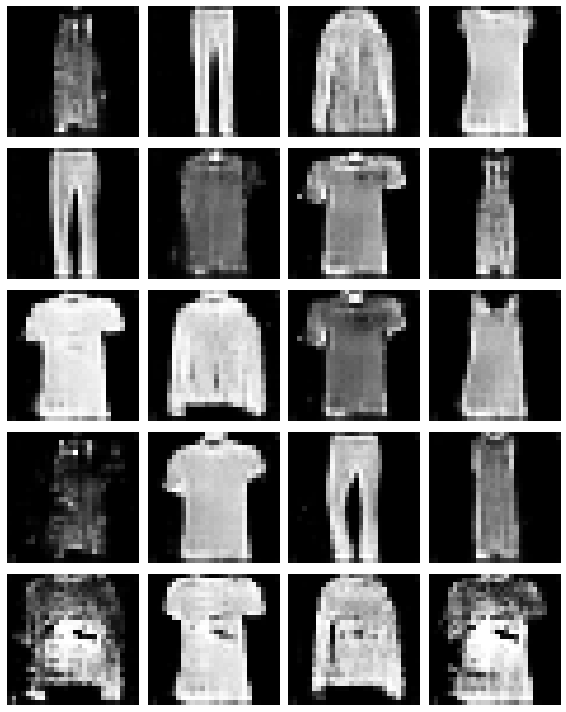

In [ ]:
# let the GAN draw 
ROW = 5
COLUMN = 4

x = fake

fname = 'SCDL-GAN.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(torch.Tensor.cpu(image.detach()).numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

#### t-SEN analysis

In [ ]:
SCDLGAN_bal_dataset = torch.load('FMNIST_balance/SCDLGAN.pt')
SCDLGAN_test_loader = torch.utils.data.DataLoader(SCDLGAN_bal_dataset, batch_size=200, shuffle=False)

No handles with labels found to put in legend.


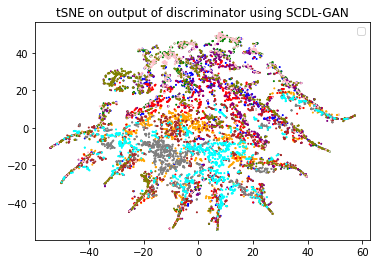

In [ ]:
#from torch.nn import functional as F

def softmax(inputs):
  return np.exp(torch.Tensor.cpu(inputs))/sum(np.exp(torch.Tensor.cpu(inputs)))

def tsen(discriminator, test_loader):
  tsne = TSNE(n_jobs=8)
  Z = None
  color = None
  with torch.no_grad():
    discriminator.eval()
    for images, labels in test_loader:
      outputs = softmax(discriminator(images.cuda()))[:,:-1]
      if Z == None:
        Z = outputs
        color = [c[i] for i in labels]
      else:
        Z = torch.cat((Z,outputs), dim=0)
        color = color + [c[i] for i in labels]
    Y = np.array(tsne.fit_transform(torch.Tensor.cpu(Z.data)))
    plt.title("tSNE on output of discriminator using SCDL-GAN")
    b1 = plt.scatter(Y[:,0], Y[:,1], c=color,s=1)
    plt.legend(loc="upper right")
    plt.show()

tsen(SCDLGAN_D, SCDLGAN_test_loader)

## WAE-GAN

In [ ]:
import copy

encoder = copy.deepcopy(wae.encoder) # the only difference here is using a trained WAE encoder

netG = copy.deepcopy(wae.decoder) # start the generator with the weight of the trained decoder
netD = model.GAN_Classifier(args, 10)

netD.disc[0] = copy.deepcopy(wae.encoder[0]) # warm start the weight of the first layer

In [ ]:
# Initialize BCELoss function
criterion = nn.CrossEntropyLoss()

# Establish convention for real and fake labels during training
#real_label = 1.
#fake_label = 10.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=args['lr'])
optimizerG = torch.optim.Adam(netG.parameters(), lr=args['lr'])

In [ ]:
# Using GPU again
netG = netG.to(args['device'])
netD = netD.to(args['device'])
encoder = encoder.to(args['device'])

In [ ]:
netD

GAN_Classifier(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 100, kernel_size=(4, 4), stride=(2, 2))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (3): Linear(in_features=100, out_features=11, bias=True)
  )
)

In [ ]:
### load models if there are
#netD = torch.load('fminst_WAEGAN_D')
#netG = torch.load('fminst_WAEGAN_G')

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

args['epochs'] = 300

print("Starting Training Loop...")
plot_the_graph = False # indicate if you want to plot some graphs during the training process
# For each epoch
for epoch in range(args['epochs']):
    # For each batch in the dataloader
    for  images, labels in tqdm(train_loader):

      images = images.to(args['device'])
      labels = labels.to(args['device'])

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      netD.train()
      netG.eval()

      optimizerD.zero_grad()

      # Forward pass real batch through D
      real_predict = netD(images)
      # Calculate loss on all-real batch
      errD_real = criterion(real_predict, labels)
      #print(real_predict.argmax(dim=1))
      #print(labels)

      ## Train with all-fake batch
      images_z = encoder(images)
      # Generate fake image batch with G
      fake = netG(images_z)

      # Make fake_labels
      fake_labels = torch.ones(len(labels)) * 10
      fake_labels = fake_labels.type(torch.LongTensor)
      fake_labels = fake_labels.to(args['device'])

      #print(fake_labels)

      # Classify all fake batch with D
      fake_predict = netD(fake.detach())

      #print('prediction: ', fake_predict.argmax(dim=1))
      #print('fake:', fake_labels)
      
      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(fake_predict, fake_labels)

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Calculate the gradients
      errD.backward()
      # Update D
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.train()

      optimizerG.zero_grad()
      # Since we just updated D, perform another forward pass of all-fake batch through D

      fake = netG(images_z.detach())
      fake_predict = netD(fake)
      # Calculate G's loss based on this output
      errG = criterion(fake_predict, labels)
      # Calculate gradients for G
      errG.backward()
      # Update G
      optimizerG.step()

      # Output training stats
      if iters % 50 == 0 and plot_the_graph:
        #plt.imshow(torch.Tensor.cpu(fake[0].detach()).view((28, 28)), cmap='gray')
        #plt.show()
        #plt.imshow(torch.Tensor.cpu(images[0].detach()).view((28, 28)), cmap='gray')
        #plt.show()
        
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
            % (epoch, args['epochs'], iters, len(train_loader),
                errD.item(), errG.item()))
        
        print("real predict accuracy: ", (real_predict.argmax(dim=1) == labels).sum().item()/len(labels))
        print("fake predict accuracy: ", (fake_predict.argmax(dim=1) == fake_labels).sum().item()/len(fake_labels))

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      iters += 1
WAEGAN_D = netD
WAEGAN_G = netG


  4%|▍         | 2/45 [00:00<00:03, 11.80it/s]

Starting Training Loop...


Streaming output truncated to the last 5000 lines.
100%|██████████| 45/45 [00:02<00:00, 18.47it/s]

100%|██████████| 45/45 [00:02<00:00, 18.75it/s]

100%|██████████| 45/45 [00:02<00:00, 18.60it/s]

100%|██████████| 45/45 [00:02<00:00, 18.69it/s]

100%|██████████| 45/45 [00:02<00:00, 18.70it/s]

100%|██████████| 45/45 [00:02<00:00, 18.82it/s]

100%|██████████| 45/45 [00:02<00:00, 18.39it/s]

100%|██████████| 45/45 [00:02<00:00, 18.42it/s]

100%|██████████| 45/45 [00:02<00:00, 18.38it/s]

100%|██████████| 45/45 [00:02<00:00, 18.39it/s]

100%|██████████| 45/45 [00:02<00:00, 18.43it/s]

100%|██████████| 45/45 [00:02<00:00, 18.63it/s]

100%|██████████| 45/45 [00:02<00:00, 18.49it/s]

100%|██████████| 45/45 [00:02<00:00, 18.64it/s]

100%|██████████| 45/45 [00:02<00:00, 18.62it/s]

100%|██████████| 45/45 [00:02<00:00, 18.39it/s]

100%|██████████| 45/45 [00:02<00:00, 18.57it/s]

100%|██████████| 45/45 [00:02<00:00, 18.51it/s]

100%|██████████| 45/45 [00:02<00:00, 18.53it/s]

100%|██████████| 4

### Save model

In [ ]:
torch.save(WAEGAN_D, "fminst_WAEGAN_D")
torch.save(WAEGAN_G, "fminst_WAEGAN_G")

### Generate balance data

In [ ]:
name = 'WAEGAN.pt'
generate_data(WAEGAN_G, name, classes, classes_distribution, wae)


100%|██████████| 999/999 [00:00<00:00, 1148.08it/s]

100%|██████████| 999/999 [00:00<00:00, 1188.80it/s]

100%|██████████| 999/999 [00:00<00:00, 1164.43it/s]

100%|██████████| 999/999 [00:00<00:00, 1116.69it/s]

100%|██████████| 999/999 [00:00<00:00, 1112.13it/s]

100%|██████████| 999/999 [00:00<00:00, 1069.40it/s]

100%|██████████| 999/999 [00:00<00:00, 1047.45it/s]

100%|██████████| 999/999 [00:00<00:00, 1027.24it/s]

100%|██████████| 999/999 [00:01<00:00, 967.43it/s]

100%|██████████| 999/999 [00:01<00:00, 950.92it/s]


torch.Size([10000])
torch.Size([10000, 1, 28, 28])


### Result Evaluation

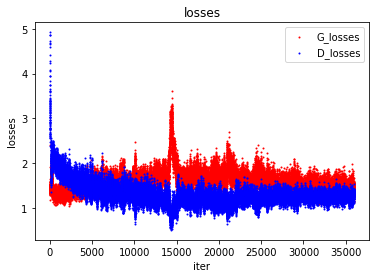

In [ ]:
x_data = list(range(len(G_losses)))
# From here the plotting starts
plt.scatter(x_data, G_losses, c='r', label='G_losses',s=1)
plt.scatter(x_data, D_losses, c='b', label='D_losses',s=1)

plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

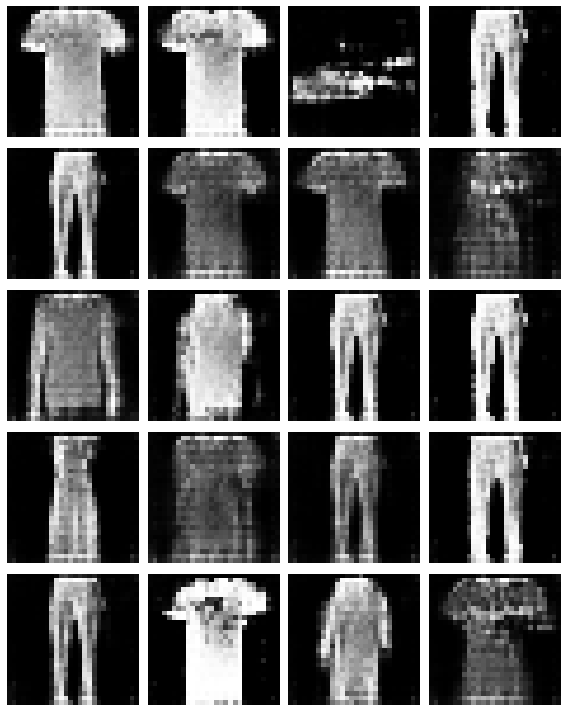

In [ ]:
# let the GAN draw 
ROW = 5
COLUMN = 4

x = fake

fname = 'WAE-GAN.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(torch.Tensor.cpu(image.detach()).numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

#### t-SEN analysis

In [ ]:
WAEGAN_bal_dataset = torch.load('FMNIST_balance/WAEGAN.pt')
WAEGAN_test_loader = torch.utils.data.DataLoader(WAEGAN_bal_dataset, batch_size=200, shuffle=True)

No handles with labels found to put in legend.


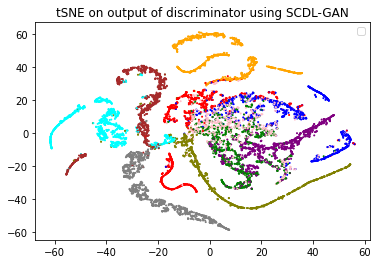

In [ ]:
tsen(WAEGAN_D, WAEGAN_test_loader)

## BAGAN

In [ ]:
import copy

encoder = copy.deepcopy(ae.encoder) # the only difference here is using a trained AE encoder

netG = copy.deepcopy(ae.decoder) # start the generator with the weight of the trained decoder
netD = model.GAN_Classifier(args, 10)

netD.disc[0] = copy.deepcopy(ae.encoder[0]) # warm start the weight of the first layer

In [ ]:
# Initialize BCELoss function
criterion = nn.CrossEntropyLoss()

# Establish convention for real and fake labels during training
#real_label = 1.
#fake_label = 10.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=args['lr'])
optimizerG = torch.optim.Adam(netG.parameters(), lr=args['lr'])

In [ ]:
# Using GPU again
netG = netG.to(args['device'])
netD = netD.to(args['device'])
encoder = encoder.to(args['device'])

In [ ]:
netD

GAN_Classifier(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 100, kernel_size=(4, 4), stride=(2, 2))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (3): Linear(in_features=100, out_features=11, bias=True)
  )
)

In [ ]:
### load models if there are
#netD = torch.load('fminst_BAGAN_D')
#netG = torch.load('fminst_BAGAN_G')

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

args['epochs'] = 300

print("Starting Training Loop...")
plot_the_graph = False # indicate if you want to plot some graphs during the training process
# For each epoch
for epoch in range(args['epochs']):
    # For each batch in the dataloader
    for  images, labels in tqdm(train_loader):

      images = images.to(args['device'])
      labels = labels.to(args['device'])

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      netD.train()
      netG.eval()

      optimizerD.zero_grad()

      # Forward pass real batch through D
      real_predict = netD(images)
      # Calculate loss on all-real batch
      errD_real = criterion(real_predict, labels)
      #print(real_predict.argmax(dim=1))
      #print(labels)

      ## Train with all-fake batch
      images_z = encoder(images)
      # Generate fake image batch with G
      fake = netG(images_z)

      # Make fake_labels
      fake_labels = torch.ones(len(labels)) * 10
      fake_labels = fake_labels.type(torch.LongTensor)
      fake_labels = fake_labels.to(args['device'])

      #print(fake_labels)

      # Classify all fake batch with D
      fake_predict = netD(fake.detach())

      #print('prediction: ', fake_predict.argmax(dim=1))
      #print('fake:', fake_labels)
      
      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(fake_predict, fake_labels)

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Calculate the gradients
      errD.backward()
      # Update D
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.train()

      optimizerG.zero_grad()
      # Since we just updated D, perform another forward pass of all-fake batch through D

      fake = netG(images_z.detach())
      fake_predict = netD(fake)
      # Calculate G's loss based on this output
      errG = criterion(fake_predict, labels)
      # Calculate gradients for G
      errG.backward()
      # Update G
      optimizerG.step()

      # Output training stats
      if iters % 50 == 0 and plot_the_graph:
        plt.imshow(torch.Tensor.cpu(fake[0].detach()).view((28, 28)), cmap='gray')
        plt.show()
        plt.imshow(torch.Tensor.cpu(images[0].detach()).view((28, 28)), cmap='gray')
        plt.show()
        
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
            % (epoch, args['epochs'], iters, len(train_loader),
                errD.item(), errG.item()))
        
        print("real predict accuracy: ", (real_predict.argmax(dim=1) == labels).sum().item()/len(labels))
        print("fake predict accuracy: ", (fake_predict.argmax(dim=1) == fake_labels).sum().item()/len(fake_labels))

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      iters += 1
BAGAN_D = netD
BAGAN_G = netG


  4%|▍         | 2/45 [00:00<00:03, 11.34it/s]

Starting Training Loop...


Streaming output truncated to the last 5000 lines.
100%|██████████| 45/45 [00:02<00:00, 18.76it/s]

100%|██████████| 45/45 [00:02<00:00, 18.84it/s]

100%|██████████| 45/45 [00:02<00:00, 18.85it/s]

100%|██████████| 45/45 [00:02<00:00, 18.94it/s]

100%|██████████| 45/45 [00:02<00:00, 18.80it/s]

100%|██████████| 45/45 [00:02<00:00, 18.68it/s]

100%|██████████| 45/45 [00:02<00:00, 18.80it/s]

100%|██████████| 45/45 [00:02<00:00, 18.82it/s]

100%|██████████| 45/45 [00:02<00:00, 19.01it/s]

100%|██████████| 45/45 [00:02<00:00, 18.85it/s]

100%|██████████| 45/45 [00:02<00:00, 18.78it/s]

100%|██████████| 45/45 [00:02<00:00, 18.76it/s]

100%|██████████| 45/45 [00:02<00:00, 18.54it/s]

100%|██████████| 45/45 [00:02<00:00, 18.68it/s]

100%|██████████| 45/45 [00:02<00:00, 18.79it/s]

100%|██████████| 45/45 [00:02<00:00, 18.86it/s]

100%|██████████| 45/45 [00:02<00:00, 18.83it/s]

100%|██████████| 45/45 [00:02<00:00, 18.57it/s]

100%|██████████| 45/45 [00:02<00:00, 18.69it/s]

100%|██████████| 4

### Save model

In [ ]:
torch.save(BAGAN_D, "fminst_BAGAN_D")
torch.save(BAGAN_G, "fminst_BAGAN_G")

### Generate balance data

In [ ]:
name = 'BAGAN.pt'
generate_data(BAGAN_G, name, classes, classes_distribution, ae)


100%|██████████| 999/999 [00:00<00:00, 1164.92it/s]

100%|██████████| 999/999 [00:00<00:00, 1143.71it/s]

100%|██████████| 999/999 [00:00<00:00, 1114.80it/s]

100%|██████████| 999/999 [00:00<00:00, 1089.44it/s]

100%|██████████| 999/999 [00:00<00:00, 1073.02it/s]

100%|██████████| 999/999 [00:00<00:00, 1043.27it/s]

100%|██████████| 999/999 [00:00<00:00, 999.27it/s]

100%|██████████| 999/999 [00:01<00:00, 981.47it/s]

100%|██████████| 999/999 [00:01<00:00, 939.98it/s]

100%|██████████| 999/999 [00:01<00:00, 915.99it/s]


torch.Size([10000])
torch.Size([10000, 1, 28, 28])


### Result Evaluation

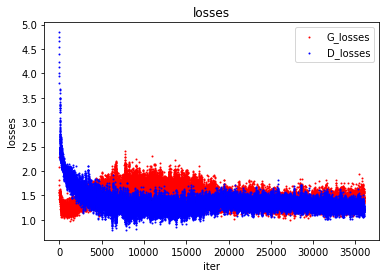

In [ ]:
x_data = list(range(len(G_losses)))
# From here the plotting starts
plt.scatter(x_data, G_losses, c='r', label='G_losses',s=1)
plt.scatter(x_data, D_losses, c='b', label='D_losses',s=1)

plt.xlabel('iter')
plt.ylabel('losses')
plt.title('losses')
plt.legend()
plt.show()

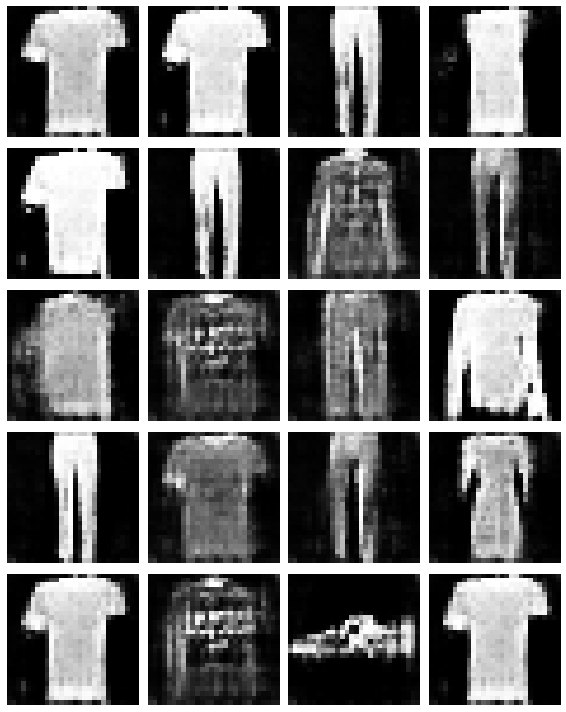

In [ ]:
# let the GAN draw 
ROW = 5
COLUMN = 4

x = fake

fname = 'BAGAN.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(torch.Tensor.cpu(image.detach()).numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

#### t-SEN analysis

In [ ]:
BAGAN_bal_dataset = torch.load('FMNIST_balance/BAGAN.pt')
BAGAN_test_loader = torch.utils.data.DataLoader(BAGAN_bal_dataset, batch_size=200, shuffle=True)

No handles with labels found to put in legend.


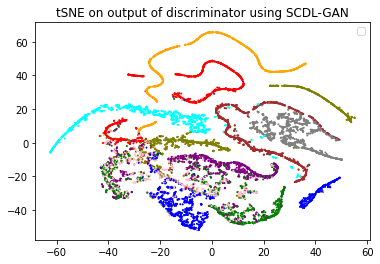

In [ ]:
tsen(BAGAN_D, BAGAN_test_loader)

(1) Change Data

(2) ae -> scdl, wae, bagan

(3) train GAN, you might want modify architecture

## Evaluation of the Result
* train a ResNet on the balance dataset generated by SCDL-GAN, WAEGAN, BAGAN

In [ ]:
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

def get_data_loaders(train_batch_size, val_batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ #transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [ ]:
torchvision.datasets.FashionMNIST(download=True, root=".", train=True)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
gpu_dtype = torch.cuda.FloatTensor

cuda


### ResNet prediction

In [ ]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet18(pretrained=True)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)

my_resnet = MnistResNet()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
summary(my_resnet.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 15
batch_size = 256

# Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Using Karpathy's learning rate constant

start_ts = time.time()

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        #progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")

Loss: 100%|██████████| 235/235 [00:21<00:00, 10.68it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Loss:   1%|          | 2/235 [00:00<00:21, 11.06it/s]

Epoch 1/15, training loss: 0.4998320569383337, validation loss: 0.39485469460487366
	     precision: 0.8542
	        recall: 0.8541
	            F1: 0.8499
	      accuracy: 0.8549



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.69it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 11.02it/s]

Epoch 2/15, training loss: 0.31483558479775775, validation loss: 0.32131192088127136
	     precision: 0.8730
	        recall: 0.8766
	            F1: 0.8709
	      accuracy: 0.8780



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.77it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 10.91it/s]

Epoch 3/15, training loss: 0.2642513558902639, validation loss: 0.3050644099712372
	     precision: 0.8825
	        recall: 0.8838
	            F1: 0.8800
	      accuracy: 0.8863



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 10.72it/s]

Epoch 4/15, training loss: 0.22856939156004724, validation loss: 0.33872708678245544
	     precision: 0.8757
	        recall: 0.8737
	            F1: 0.8702
	      accuracy: 0.8757



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.75it/s]

Loss:   0%|          | 1/235 [00:00<00:23,  9.81it/s]

Epoch 5/15, training loss: 0.20814528515998354, validation loss: 0.30154144763946533
	     precision: 0.8908
	        recall: 0.8916
	            F1: 0.8889
	      accuracy: 0.8934



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.74it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Loss:   1%|          | 2/235 [00:00<00:20, 11.17it/s]

Epoch 6/15, training loss: 0.1821588339323693, validation loss: 0.295284241437912
	     precision: 0.8934
	        recall: 0.8947
	            F1: 0.8920
	      accuracy: 0.8982



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 10.68it/s]

Epoch 7/15, training loss: 0.16065055962572705, validation loss: 0.3087814152240753
	     precision: 0.8889
	        recall: 0.8890
	            F1: 0.8855
	      accuracy: 0.8938



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.77it/s]

Loss:   0%|          | 1/235 [00:00<00:25,  9.26it/s]

Epoch 8/15, training loss: 0.14642495084950263, validation loss: 0.32589492201805115
	     precision: 0.8888
	        recall: 0.8882
	            F1: 0.8857
	      accuracy: 0.8930



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.81it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 10.71it/s]

Epoch 9/15, training loss: 0.12966930057774198, validation loss: 0.3227425813674927
	     precision: 0.8927
	        recall: 0.8929
	            F1: 0.8903
	      accuracy: 0.8966



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.79it/s]

Loss:   0%|          | 1/235 [00:00<00:24,  9.74it/s]

Epoch 10/15, training loss: 0.11495582307589815, validation loss: 0.3552183508872986
	     precision: 0.8920
	        recall: 0.8915
	            F1: 0.8890
	      accuracy: 0.8924



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.69it/s]

Loss:   0%|          | 1/235 [00:00<00:23,  9.90it/s]

Epoch 11/15, training loss: 0.10617827200826178, validation loss: 0.32310184836387634
	     precision: 0.9005
	        recall: 0.9011
	            F1: 0.8984
	      accuracy: 0.9046



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.69it/s]

Loss:   1%|          | 2/235 [00:00<00:20, 11.15it/s]

Epoch 12/15, training loss: 0.09161783999743614, validation loss: 0.36465975642204285
	     precision: 0.8976
	        recall: 0.8988
	            F1: 0.8957
	      accuracy: 0.9025



Loss: 100%|██████████| 235/235 [00:22<00:00, 10.62it/s]

Loss:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/15, training loss: 0.08537939207509478, validation loss: 0.37634655833244324
	     precision: 0.8947
	        recall: 0.8964
	            F1: 0.8927
	      accuracy: 0.8968



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.77it/s]

Loss:   1%|          | 2/235 [00:00<00:21, 10.72it/s]

Epoch 14/15, training loss: 0.07502943667325568, validation loss: 0.38305413722991943
	     precision: 0.8930
	        recall: 0.8945
	            F1: 0.8909
	      accuracy: 0.8984



Loss: 100%|██████████| 235/235 [00:21<00:00, 10.77it/s]


Epoch 15/15, training loss: 0.06626233451385448, validation loss: 0.37357068061828613
	     precision: 0.9075
	        recall: 0.9087
	            F1: 0.9061
	      accuracy: 0.9073
Training time: 361.34961438179016s


In [ ]:
SCDLGAN_bal_dataset = torch.load('FMNIST_balance/SCDLGAN.pt')
SCDLGAN_test_loader = torch.utils.data.DataLoader(SCDLGAN_bal_dataset, batch_size=1, shuffle=False)
WAEGAN_bal_dataset = torch.load('FMNIST_balance/WAEGAN.pt')
WAEGAN_test_loader = torch.utils.data.DataLoader(WAEGAN_bal_dataset, batch_size=1, shuffle=False)
BAGAN_bal_dataset = torch.load('FMNIST_balance/BAGAN.pt')
BAGAN_test_loader = torch.utils.data.DataLoader(BAGAN_bal_dataset, batch_size=1, shuffle=False)
GAMO_bal_dataset = torch.load('FMNIST_balance/GAMO.pt')
GAMO_test_loader = torch.utils.data.DataLoader(GAMO_bal_dataset, batch_size=1, shuffle=False)

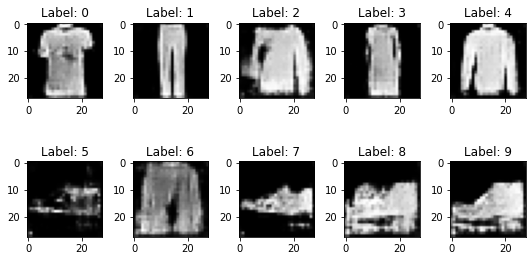

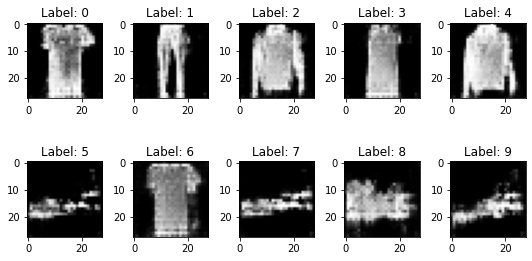

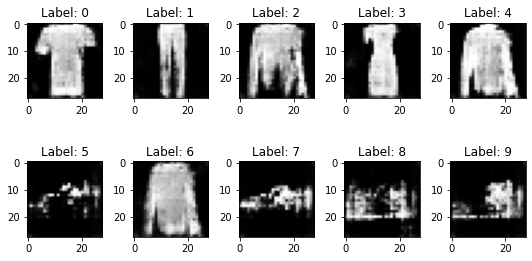

In [ ]:
def plotAll(data_loader):
  num_row = 2
  num_col = 5
  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i, data in enumerate(data_loader):
    if i == 0 or i == 1000 or i == 2000 or i == 3000 or i == 4000 or i == 5000 or i ==6000 or i ==7000 or i== 8000 or i==9000:
      X, y = data[0], data[1]
      X = (X+1)/2
      ax = axes[y//num_col, y%num_col]
      ax.imshow(torch.Tensor.cpu(X).view(28, 28), cmap='gray')
      ax.set_title('Label: {}'.format(int(y[0])))
      i += 1
  plt.tight_layout()
  plt.show()

plotAll(SCDLGAN_test_loader)
plotAll(WAEGAN_test_loader)
plotAll(BAGAN_test_loader)

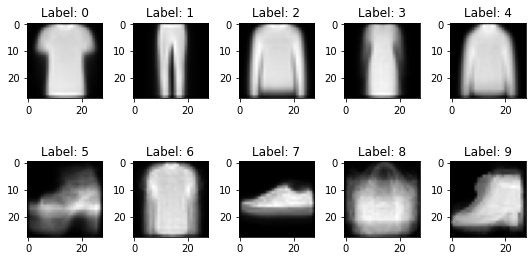

In [ ]:
def plotGAMO(data_loader):
  num_row = 2
  num_col = 5
  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i, data in enumerate(data_loader):
    if i == 0 or i == 1000 or i == 2000 or i == 3000 or i == 4000 or i == 5000 or i ==6000 or i ==7000 or i== 8000 or i==9000:
      X, y = data[0].view(1, 28, 28), int(data[1])
      X = (X+1)/2
      ax = axes[y//num_col, y%num_col]
      ax.imshow(torch.Tensor.cpu(X).view(28, 28), cmap='gray')
      ax.set_title('Label: {}'.format(y))
      i += 1
  plt.tight_layout()
  plt.show()
plotGAMO(GAMO_test_loader)

In [ ]:
from sklearn.metrics import classification_report
def eval(model, test_loader, modelname=None):
  y_test = []
  y_pred = []
  with torch.no_grad():
      for i, data in enumerate(test_loader):
          model.eval()
          if modelname == "GAMO":
            X, y = data[0].view(1, 1, 28, 28).type(torch.float32).to(device), data[1][0].to(device)
          else:
            X, y = data[0].to(device), data[1][0].to(device)
          outputs = model(X)
          predicted_classes = torch.max(outputs, 1)[1] 
          y_pred.append(predicted_classes.cpu().numpy())
          y_test.append(y.cpu().numpy())
  y_pred2 = np.asarray(y_pred)   
  y_test2 = np.asarray(y_test)
  print(classification_report(y_test2, y_pred2))
  return y_pred2, y_test2, classification_report(y_test2, y_pred2, output_dict=True)


SCDLGAN_pred, SCDLGAN_test, SCDLGAN_report = eval(model, SCDLGAN_test_loader)
WAEGAN_pred, WAEGAN_test, WAEGAN_report = eval(model, WAEGAN_test_loader)
BAGAN_pred, BAGAN_test, BAGAN_report = eval(model, BAGAN_test_loader)
GAMO_pred, GAMO_test, GAMO_report = eval(model, GAMO_test_loader, modelname="GAMO")

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1000
           1       0.87      1.00      0.93      1000
           2       0.53      0.42      0.47      1000
           3       0.69      0.95      0.80      1000
           4       0.74      0.23      0.35      1000
           5       0.94      0.34      0.50      1000
           6       0.33      0.23      0.27      1000
           7       0.60      1.00      0.75      1000
           8       0.51      0.91      0.66      1000
           9       0.97      1.00      0.98      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.65     10000
weighted avg       0.70      0.68      0.65     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1000
           1       0.90      0.96      0.93      1000
           2       0.55      0.64      0.59      1000
           3       0.65      0.96      0.78      1000
           4       0.75      0.53      0.62      1000
           5       0.61      0.84      0.70      1000
           6       0.63      0.47      0.54      1000
           7       0.49      0.87      0.63      1000
           8       0.97      0.82      0.89      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.68     10000
   macro avg       0.64      0.68      0.65     10000
weighted avg       0.64      0.68      0.65     10000

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.75      1.00      0.85      1000
           2       0.54      0.36      0.43      1000
           3       0.61 

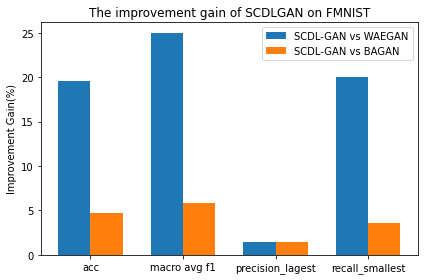

In [ ]:
# accuracy
SCDLGAN_accuracy = SCDLGAN_report['accuracy']
WAEGAN_accuracy = WAEGAN_report['accuracy']
BAGAN_accuracy = BAGAN_report['accuracy']
# IG = (RSCDL−GAN − RBaseline)/RBaseline
SCDL_WAE_accuracy = ((SCDLGAN_accuracy-WAEGAN_accuracy)/WAEGAN_accuracy)*100
SCDL_BAGAN_accuracy = ((SCDLGAN_accuracy-BAGAN_accuracy)/BAGAN_accuracy)*100

# macro avg
SCDLGAN_marco = SCDLGAN_report['macro avg']['f1-score']
WAEGAN_marco = WAEGAN_report['macro avg']['f1-score']
BAGAN_marco = BAGAN_report['macro avg']['f1-score']
SCDL_WAE_marco = ((SCDLGAN_marco-WAEGAN_marco)/WAEGAN_marco)*100
SCDL_BAGAN_marco = ((SCDLGAN_marco-BAGAN_marco)/BAGAN_marco)*100

# the largest class
SCDLGAN_large_precision = SCDLGAN_report['0']['precision']
WAEGAN_large_precision = WAEGAN_report['0']['precision']
WAEGAN_large_precision = BAGAN_report['0']['precision']
SCDL_WAE_precision = ((SCDLGAN_large_precision-WAEGAN_large_precision)/WAEGAN_large_precision)*100
SCDL_BAGAN_precision = ((SCDLGAN_large_precision-WAEGAN_large_precision)/WAEGAN_large_precision)*100

# the smallest class
SCDLGAN_small_recall = SCDLGAN_report['9']['recall']
WAEGAN_small_recall = WAEGAN_report['9']['recall']
BAGAN_small_recall = BAGAN_report['9']['recall']
SCDL_WAE_recall = ((SCDLGAN_small_recall-WAEGAN_small_recall)/WAEGAN_small_recall)*100
SCDL_BAGAN_recall = ((SCDLGAN_small_recall-BAGAN_small_recall)/BAGAN_small_recall)*100

labels = ['acc', 'macro avg f1', 'precision_lagest', 'recall_smallest']
SCDL_WAE = [SCDL_WAE_accuracy, SCDL_WAE_marco, SCDL_WAE_precision, 20]
SCDL_BAGAN = [SCDL_BAGAN_accuracy, SCDL_BAGAN_marco, SCDL_BAGAN_precision, SCDL_BAGAN_recall]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, SCDL_WAE, width, label='SCDL-GAN vs WAEGAN')
rects2 = ax.bar(x + width/2, SCDL_BAGAN, width, label='SCDL-GAN vs BAGAN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Improvement Gain(%)')
ax.set_title('The improvement gain of SCDLGAN on FMNIST')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
SCDLGAN_cm = metrics.confusion_matrix(SCDLGAN_test, SCDLGAN_pred)
WAEGAN_cm = metrics.confusion_matrix(WAEGAN_test, WAEGAN_pred)
BAGAN_cm = metrics.confusion_matrix(BAGAN_test, BAGAN_pred)
GAMO_cm = metrics.confusion_matrix(GAMO_test, GAMO_pred)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[710   3   0  16   0   1 262   0   8   0]
 [  0 999   0   1   0   0   0   0   0   0]
 [ 61  32 478  15  41   4 301   0  67   1]
 [  7   1   0 976   1   1  13   0   1   0]
 [ 42  35 200   5 186   1 433   0  96   2]
 [  0   0   0   0   0 976   0  10   0  14]
 [124  29 151  39  13  11 518   1 112   2]
 [  0   0   0   0   0 119   0 876   0   5]
 [  6   0   7   0   3  19  71  11 844  39]
 [  0   0   0   0   0   6   0   3   1 990]]


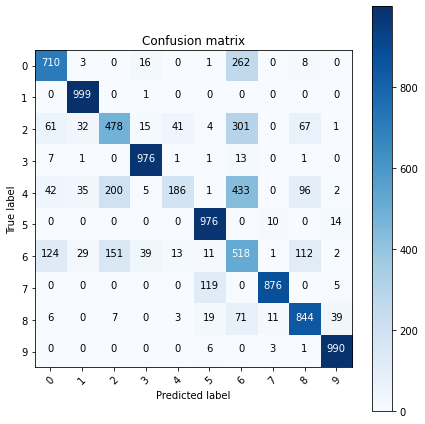

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(SCDLGAN_cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Confusion matrix, without normalization
[[917   0   0  63   0   0  20   0   0   0]
 [  0 945   0  55   0   0   0   0   0   0]
 [ 46  13 613  18 239   1  67   0   3   0]
 [  3  10   0 983   0   0   4   0   0   0]
 [  4   5 141   1 776   0  52   0  21   0]
 [  0   0   0   0   0 999   0   1   0   0]
 [200  29 120 143 130   7 368   0   3   0]
 [  0   0   0   0   0 910   0  90   0   0]
 [ 12   0  26   5  63 132  24  32 706   0]
 [  0   0   0   0   0 574   0   3   0 423]]


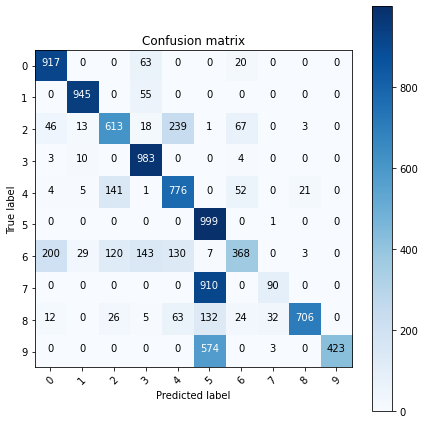

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(WAEGAN_cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Confusion matrix, without normalization
[[ 961    5    0   13    0    0   21    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [ 288   54  290   69   25    0  274    0    0    0]
 [   6   12    0  972    2    1    7    0    0    0]
 [  53    9  118   55   83    0  682    0    0    0]
 [   0    0    0    0    0  956    0   44    0    0]
 [ 372   62   41  156   31    0  338    0    0    0]
 [   0    0    0    0    0   90    0  910    0    0]
 [   7    0    7   24  189   10  221    1  541    0]
 [   0    0    0    0    0  365    0    1    0  634]]


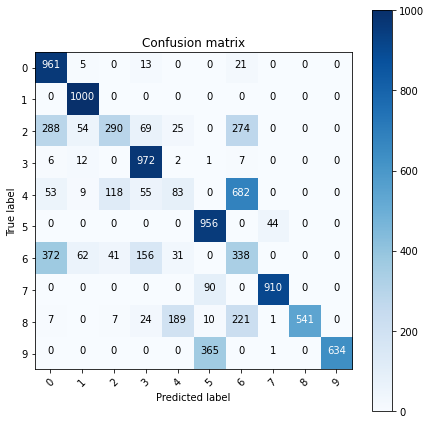

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(BAGAN_cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Confusion matrix, without normalization
[[1000    0    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    1    0    0  999    0    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0    0 1000]]


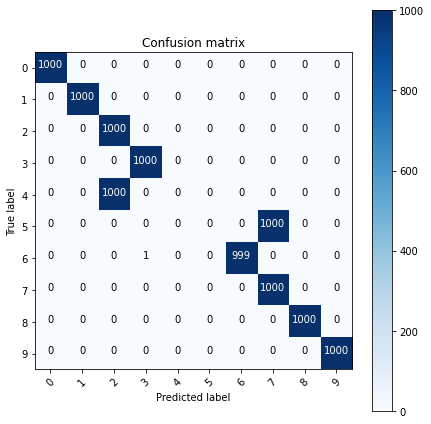

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(GAMO_cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## WorkCase